In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only works in Colab.
  %tensorflow_version 2.x
except Exception:
  print('TensorFlow 2.x not found')

TensorFlow 2.x selected.


In [2]:
"""Single-step univariate time series LSTM reference model
Ref: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/
Adapted to work in the ms-sandbox project structure.  This script runs the
model fitting multiple times.
"""
from math import sqrt

import numpy
import tensorflow as tf
from matplotlib import pyplot
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import datetime
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential


# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190' + x, '%Y-%m')


# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag + 1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df


# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]


# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled


# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]


# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons,
                   batch_input_shape=(batch_size, X.shape[1], X.shape[2]),
                   stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0,
                  shuffle=False)
        model.reset_states()
    return model


# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0, 0]


# Output TensorFlow and Keras version
print('TensorFlow version:', tf.__version__)
print('TensorFlow Keras version:', tf.keras.__version__)

# load dataset
series = read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0],
                  index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

TensorFlow version: 2.1.0
TensorFlow Keras version: 2.2.4-tf


In [3]:
%%time
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled) + 1 - i)
        # store forecast
        predictions.append(yhat)
    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
    print('%2d) Test RMSE: %.3f' % (r + 1, rmse))
    error_scores.append(rmse)

 1) Test RMSE: 115.115
 2) Test RMSE: 143.310
 3) Test RMSE: 247.959
 4) Test RMSE: 140.139
 5) Test RMSE: 133.423
 6) Test RMSE: 107.845
 7) Test RMSE: 94.771
 8) Test RMSE: 126.582
 9) Test RMSE: 116.518
10) Test RMSE: 115.185
11) Test RMSE: 127.926
12) Test RMSE: 173.822
13) Test RMSE: 132.829
14) Test RMSE: 139.058
15) Test RMSE: 150.448
16) Test RMSE: 108.103
17) Test RMSE: 91.254
18) Test RMSE: 91.918
19) Test RMSE: 187.205
20) Test RMSE: 112.092
21) Test RMSE: 168.451
22) Test RMSE: 99.203
23) Test RMSE: 171.186
24) Test RMSE: 163.494
25) Test RMSE: 98.435
26) Test RMSE: 118.263
27) Test RMSE: 111.396
28) Test RMSE: 111.527
29) Test RMSE: 131.220
30) Test RMSE: 101.331
CPU times: user 2h 19min 52s, sys: 8min 39s, total: 2h 28min 32s
Wall time: 1h 53min 33s


             rmse
count   30.000000
mean   131.000183
std     34.184746
min     91.253769
25%    108.926050
50%    122.422503
75%    142.517233
max    247.958797


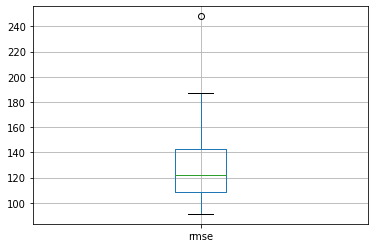

In [4]:
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()